## Reference
`Literatures` "Introduction of EM Algorithm into Color Image Segmentation", Tatsuya Yamazaki, 1998 <br>

`Code` https://github.com/EtiPoc/GraphicalModels/blob/master/EM.py <br>

**Remarks**
1. The reference script implements slow computation. A few modifications are made to speed up the computation
2. Most computation below follows the formula offered by the reference literature

**Self-help Resources**
1. Sklearn GMM  https://scikit-learn.org/stable/modules/mixture.html

**To Be Done**
1. Different ways of initialisation
2. Apply space other than color space
3. LaTex formula

**Difficulties**
1. Convert formula into matrix operations [Done]
2. Rewrite the script in R
3. Covariance matrix update is expensive
4. Auto-determination of k
5. Numerical problem arise when k is high (inf / 0)

In [8]:
import numpy as np
import scipy.stats
import math
import cv2
from scipy import ndimage
# Try Kmeans from diffrerent packages
from sklearn import cluster
from scipy.cluster.vq import kmeans2
import matplotlib.pyplot as plt
from scipy import ndimage
import imageio
%matplotlib inline

In [2]:
FILENAME1 = './img/Co6q3lrygK-AbzQ0AAKvDylHHq4008.jpg'
FILENAME2 = './img/Co6q6Fry23KAGdrRAAJBxxyYEHQ922.jpg'
X = 800
Y = 800
Z = 3

### IMAGE PROCEDURES

In [9]:
# input fllename >> output 3d array
def read_img(filename):
    img_3d = imageio.imread(filename)
    return img_3d

# input 3d array >> output 2d array
def flatten_img(img_3d):
    x, y, z = img_3d.shape
    img_2d = img_3d.reshape(x*y, z)
    img_2d = np.array(img_2d, dtype = np.float)
    return img_2d

# input 2d array >> output 3d array
def recover_img(img_2d, vis = False):
    recover_img = img_2d.reshape(X, Y, Z)
    return recover_img

### INITIALIZATION

In [4]:
# input 2d array >> output estimated means, stds, pis
def kmeans_init(img, k):
    means, labels = kmeans2(img, k)
    means = np.array(means)
    cov = np.array([np.cov(img[labels == i].T) for i in range(k)])
    ids = set(labels)
    pis = np.array([np.sum([labels == i]) / len(labels) for i in ids])
    return means, cov, pis

### E-STEP AND M-STEP

In [14]:
# E-Step: Update Parameters
# update the conditional pdf - prob that pixel i given class j
def update_responsibility(img, means, cov, pis, k):
    # responsibilities: i th pixels, j th class
    # pis * gaussian.pdf
    responsibilities = np.array([pis[j] * scipy.stats.multivariate_normal.pdf(img, mean=means[j], cov=cov[j]) for j in range(k)]).T
    # normalize for each row
    norm = np.sum(responsibilities, axis = 1)
    # convert to column vector
    norm = np.reshape(norm, (len(norm), 1))
    responsibilities = responsibilities / norm
    return responsibilities

# update pi for each class of Gaussian model
def update_pis(responsibilities):
    pis = np.sum(responsibilities, axis = 0) / responsibilities.shape[0]
    return pis

# update means for each class of Gaussian model
def update_means(img, responsibilities):
    means = []
    class_n = responsibilities.shape[1]
    for j in range(class_n):
        weight = responsibilities[:, j] / np.sum(responsibilities[:, j])
        weight = np.reshape(weight, (1, len(weight)))
        means_j = weight.dot(img)
        means.append(means_j[0])
    means = np.array(means)
    return means

# update covariance matrix for each class of Gaussian model
def update_covariance(img, responsibilities, means):
    cov = []
    class_n = responsibilities.shape[1]
    for j in range(class_n):
        weight = responsibilities[:, j] / np.sum(responsibilities[:, j])
        weight = np.reshape(weight, (1, len(weight)))
        # Each pixels have a covariance matrices
        covs = [np.mat(i - means[j]).T * np.mat(i - means[j]) for i in img]
        # Weighted sum of covariance matrices
        cov_j = sum(weight[0][i] * covs[i] for i in range(len(weight[0])))
        cov.append(cov_j)
    cov = np.array(cov)
    return cov

# M-step: choose a label that maximise the likelihood
def update_labels(responsibilities):
    labels = np.argmax(responsibilities, axis = 1)
    return labels

def update_loglikelihood(img, means, cov, pis, k):
    # was pdf instead of ll
    pdf = np.array([pis[j] * scipy.stats.multivariate_normal.pdf(img, mean=means[j], cov=cov[j]) for j in range(k)])
    log_ll = np.log(np.sum(ll, axis = 0))
    log_ll_sum = np.sum(log_ll)
    return log_ll_sum

### EM ALGORITHM

In [6]:
def EM_cluster(img, k, error = 10e-4, iter_n = 9999):
    #  init setting
    cnt = 0
    likelihood_arr = []
    # Initialise E-Step by KMeans
    means, cov, pis = kmeans_init(img, k)
    likelihood = 0
    new_likelihood = 2
    responsibilities = update_responsibility(img, means, cov, pis, k)
    while (abs(likelihood - new_likelihood) > error) and (cnt != 9999):
        cnt += 1
        likelihood = new_likelihood
        # M-Step
        labels = update_labels(responsibilities)
        # E-step
        responsibilities = update_responsibility(img, means, cov, pis, k)
        means = update_means(img, responsibilities)
        cov = update_covariance(img, responsibilities, means)
        pis = update_pis(responsibilities)
        new_likelihood = update_loglikelihood(img, means, cov, pis, k)
        likelihood_arr.append(new_likelihood)
    likelihood_arr = np.array(likelihood_arr)
    print('Converge at iteration {}'.format(cnt + 1))
    return labels, means, cov, pis, likelihood_arr

### MAIN RUN

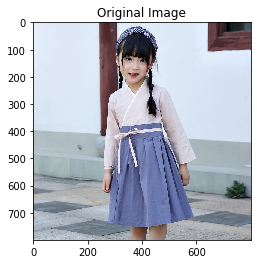

In [10]:
orig_img = read_img(FILENAME2)
plt.imshow(orig_img)
plt.title('Original Image');

In [11]:
img = flatten_img(read_img(FILENAME2))

c:\programdata\anaconda2\envs\python36\lib\site-packages\scipy\cluster\vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


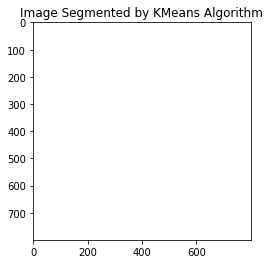

In [12]:
k_means, k_labels = kmeans2(img, 5)
kmeans_img = recover_img(k_means[k_labels])
plt.imshow(kmeans_img);
plt.title('Image Segmented by KMeans Algorithm');

In [15]:
labels, means, cov, pis, likelihood_arr = EM_cluster(img, 5)

C:\Users\jem\AppData\Roaming\Python\Python36\site-packages\numpy\lib\function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\jem\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\programdata\anaconda2\envs\python36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Degrees of freedom <= 0 for slice
  """
C:\Users\jem\AppData\Roaming\Python\Python36\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\jem\AppData\Roaming\Python\Python36\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


ValueError: array must not contain infs or NaNs

In [ ]:
em_img = recover_img(means[labels])

In [ ]:
plt.imshow(em_img)
plt.title('Image Segmented by EM Algorithm');

### Summary

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (12, 12))
ax1.imshow(kmeans_img)
ax2.imshow(em_img)
ax3.hist(k_labels, color = 'blue')
ax4.hist(labels, color = 'red')
ax1.set_title('Segmented Image by KMeans (K = 5)', fontdict = {'fontsize': 14})
ax2.set_title('Segmented Image by EM (K = 5)', fontdict = {'fontsize': 14});
ax3.set_title('Cluster Histogram by KMeans (K = 5)', fontdict = {'fontsize': 14})
ax4.set_title('Cluster Histogram by EM (K = 5)', fontdict = {'fontsize': 14});